# Predicting FPL Points from previous week data

Continuing from earlier [notebook](https://www.kaggle.com/code/ianpetrustan/football-fpl-project-analysis-and-visualisations?scriptVersionId=154988822), we focus more on making predictions for points based on the previous week's metrics. 

This could inform us on who is likely to do well in the next game, and therefore potentially a good buy for one's FPL team.

In [2]:
## Libraries 

import pandas as pd
import requests 
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

## Entire dataset as JSON

In [3]:
## Getting the data 

url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(url)
data = response.json()

## Types of sub-data contained within data 
pprint(data, depth = 1)

{'element_stats': [...],
 'element_types': [...],
 'elements': [...],
 'events': [...],
 'game_settings': {...},
 'phases': [...],
 'teams': [...],
 'total_players': 10564653}


## 1. Player overall data (static)

In [4]:
## Player overall data 
player_data = data['elements']
player_data_df = pd.json_normalize(player_data)

## Checks for player overall data
print(player_data_df.columns)
print(player_data_df.shape)

## Cleaning player overall data
player_data_df['player_name'] = player_data_df['first_name'] + ' ' + player_data_df['second_name']

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam',
       'news', 'news_added', 'now_cost', 'photo', 'points_per_game',
       'second_name', 'selected_by_percent', 'special', 'squad_number',
       'status', 'team', 'team_code', 'total_points', 'transfers_in',
       'transfers_in_event', 'transfers_out', 'transfers_out_event',
       'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_con

* 773 players in the league
* 88 possible attributes, such as cost changes, goals/assists, ICT values and rankings, points per game, etc

## 2. Teams data (Static)

In [5]:
team_data = data['teams']
team_data_df = pd.json_normalize(team_data)

## Check
print(team_data_df.columns)
print(team_data_df.shape)
# team_data_df.head()


Index(['code', 'draw', 'form', 'id', 'loss', 'name', 'played', 'points',
       'position', 'short_name', 'strength', 'team_division', 'unavailable',
       'win', 'strength_overall_home', 'strength_overall_away',
       'strength_attack_home', 'strength_attack_away', 'strength_defence_home',
       'strength_defence_away', 'pulse_id'],
      dtype='object')
(20, 21)


* 20 teams
* 21 possible attributes such as strength of attack at home and away

## 3. Player Position Data (Static) 

In [6]:
position_data = data['element_types']
position_data_df = pd.json_normalize(position_data)

## Check
print(position_data_df.shape)
print(position_data_df.columns)
# positions_data_df

(4, 11)
Index(['id', 'plural_name', 'plural_name_short', 'singular_name',
       'singular_name_short', 'squad_select', 'squad_min_play',
       'squad_max_play', 'ui_shirt_specific', 'sub_positions_locked',
       'element_count'],
      dtype='object')


* 4 possible positions

In [7]:
player_data_df.element_type.unique()

array([4, 2, 3, 1])

# Merging datasets 

First, check for duplicated column names

In [8]:
print(f'Cols in team that are also in player df are :{team_data_df.columns[team_data_df.columns.isin(player_data_df.columns)]}')
print(f'Cols in position that are also in player df are :{position_data_df.columns[position_data_df.columns.isin(player_data_df.columns)]}')

Cols in team that are also in player df are :Index(['code', 'form', 'id'], dtype='object')
Cols in position that are also in player df are :Index(['id'], dtype='object')


In [9]:
## Merge team data into player data 
player_team_df = pd.merge(left = player_data_df, right = team_data_df, 
        left_on = 'team',
        right_on = 'id')
print(f'Shape after merge once {player_team_df.shape}')

## Merge position data into team and player data
full_data_df =  pd.merge(left = player_team_df, right = position_data_df, 
        left_on = 'element_type', ## representing player position
        right_on = 'id') 
print(f'Shape after merge twice {full_data_df.shape}')


Shape after merge once (775, 110)
Shape after merge twice (775, 121)


In [10]:
position_data_df

,id,plural_name,plural_name_short,singular_name,singular_name_short,squad_select,squad_min_play,squad_max_play,ui_shirt_specific,sub_positions_locked,element_count
0,1,Goalkeepers,GKP,Goalkeeper,GKP,2,1,1,True,[12],88
1,2,Defenders,DEF,Defender,DEF,5,3,5,False,[],250
2,3,Midfielders,MID,Midfielder,MID,5,2,5,False,[],338
3,4,Forwards,FWD,Forward,FWD,3,1,3,False,[],99


In [11]:
## Check resultant df 
# full_data_df.columns.tolist()
print(full_data_df.columns[full_data_df.columns.str.endswith('_x')])
print(full_data_df.columns[full_data_df.columns.str.endswith('_y')])

## Rename columns that were meant for player data
for col in full_data_df.columns[full_data_df.columns.str.endswith('_x')]:
    full_data_df.rename(columns = {col:col.replace('x', 'player')}, inplace = True)
## Rename columns that were meant for team data
for col in full_data_df.columns[full_data_df.columns.str.endswith('_y')]:
    full_data_df.rename(columns = {col:col.replace('y', 'team')}, inplace = True) 


Index(['code_x', 'form_x', 'id_x'], dtype='object')
Index(['code_y', 'form_y', 'id_y'], dtype='object')


# Getting player history for points 

For each player and his player ID (PID), we get the gameweek points history from https://fantasy.premierleague.com/api/element-summary/{PID}/, replacing {PID} with the player's actual PID

In [12]:
base_url = 'https://fantasy.premierleague.com/api/'

## Create a function that produces an entire history dataframe for a particular player
## given his player ID (PID)
def get_player_history(pid):
    player_hist_json = requests.get(
        base_url + 'element-summary/' + str(pid) + '/' ).json()
    player_hist_df = pd.json_normalize(player_hist_json['history']) ## use 'history' to get player current season history 
    
    return(player_hist_df)

In [13]:
## Iterate the player_history function over all PIDs
from tqdm.auto import tqdm
tqdm.pandas()

histories_list = full_data_df['id_player'].progress_apply(get_player_history) ## saves a list of dataframes 
full_history_df = pd.concat(history for history in histories_list) ## use list comprehension

  0%|          | 0/775 [00:00<?, ?it/s]

In [14]:
# print(full_history_df.columns)
# print(full_data_df.columns.tolist())
# print(full_data_df.position.value_counts())

In [15]:
## Add in player name, position, now_cost, points_per_game
augmented_full_history_df = full_data_df[['id_player','team', 'player_name', 'element_type',
                                          'now_cost', 
                                          'singular_name', ## singular_name for position 
                               'points_per_game', 'selected_by_percent']].merge(
full_history_df, 
left_on = 'id_player', ## match on player ID from full_data_df (original)
right_on = 'element') ## match on element column of newly collected histories

augmented_full_history_df.drop(columns = 'element', inplace = True)
augmented_full_history_df.rename(columns = {'element_type': 'position_code',
                                 'singular_name': 'position'}, inplace = True)

## Cleaning 

In [16]:
## Select columns that are objects but meant to be numeric 
cols_to_convert = augmented_full_history_df.select_dtypes(include = 'object').columns.drop(['player_name', 'kickoff_time', 
                                                                                           'position'])

## Convert object columns to numeric columns 
for col in cols_to_convert:
    augmented_full_history_df[col] = pd.to_numeric(augmented_full_history_df[col])

# Modelling Points

## 1. Getting a subset of top players

We have many players in the dataset that do not start and often get 0 points (benched players, injured players, reserved players etc). Hence we do not want to include them in the training data

In [17]:
max_points_per_game = augmented_full_history_df.points_per_game.max().round()
max_points_per_game = int(max_points_per_game)

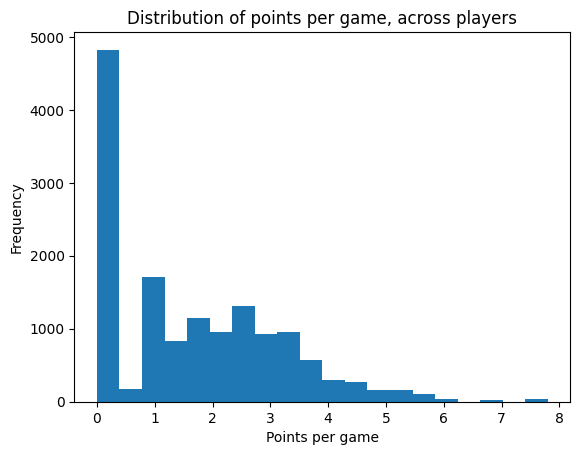

Original df shape (14487, 43)
Resultant df shape (9703, 43)


In [18]:
## Plot out the distribution of points per game 
augmented_full_history_df.points_per_game.plot(kind = 'hist', bins = 20)
plt.title('Distribution of points per game, across players')
plt.xlabel('Points per game')
# plt.xticks([x + 0.5 for x in range(0, max_points_per_game)], range(max_points_per_game))
plt.show()

## Subset 
subset_history = augmented_full_history_df[augmented_full_history_df.points_per_game > 0]
## Check diff
print(f'Original df shape {augmented_full_history_df.shape}')
print(f'Resultant df shape {subset_history.shape}')

## 2. Feature selection

* Include some measure of form using past week points (e.g. average of past n game points)
* Do same for ICT values (interact with position)
* Include lagged start 
* Include baseline (points per game)
* Include position, team
* Include selected_by_percent ('market information')

In [19]:
# subset_history.columns

In [20]:
further_subset = subset_history[['total_points', 'position', 'points_per_game', 
                                'selected_by_percent', 'influence', 'threat', 'creativity', 
                                'starts', 'team', 'player_name']] 

### Add in rolling average (n = 3) for points

In [21]:
rolling_avg_series = further_subset.groupby('player_name')['total_points'].rolling(window = 3).mean()
rolling_avg_series = rolling_avg_series.reset_index(level = 0, drop = True)
further_subset['rolling_average_points'] = rolling_avg_series

/tmp/ipykernel_42/2923115188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  further_subset['rolling_average_points'] = rolling_avg_series


In [22]:
## Check that rolling average correctly added 
further_subset[['player_name', 'total_points', 'rolling_average_points']].head()

,player_name,total_points,rolling_average_points
20,Gabriel Fernando de Jesus,0,NaN
21,Gabriel Fernando de Jesus,0,NaN
22,Gabriel Fernando de Jesus,1,0.333333
23,Gabriel Fernando de Jesus,6,2.333333
24,Gabriel Fernando de Jesus,1,2.666667


### Add in rolling average for ICT values

In [23]:
for col in ['threat', 'influence', 'creativity']:
    rolling_avg_series = further_subset.groupby('player_name')[col].rolling(window = 3).mean()
    rolling_avg_series = rolling_avg_series.reset_index(level = 0, drop = True)
    further_subset[f'rolling_average_{col}'] = rolling_avg_series


/tmp/ipykernel_42/740028156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  further_subset[f'rolling_average_{col}'] = rolling_avg_series
/tmp/ipykernel_42/740028156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  further_subset[f'rolling_average_{col}'] = rolling_avg_series
/tmp/ipykernel_42/740028156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [24]:
## Check 
further_subset[['player_name', 'rolling_average_threat', 'rolling_average_creativity', 'rolling_average_influence' ]].head()

,player_name,rolling_average_threat,rolling_average_creativity,rolling_average_influence
20,Gabriel Fernando de Jesus,NaN,NaN,NaN
21,Gabriel Fernando de Jesus,NaN,NaN,NaN
22,Gabriel Fernando de Jesus,11.666667,0.100000,1.000000
23,Gabriel Fernando de Jesus,19.333333,3.866667,12.666667
24,Gabriel Fernando de Jesus,20.000000,3.966667,13.000000


### Add lagged values for rolling average for ICT, points, and selected_by_percent

In [25]:
cols_to_lag = [f'rolling_average_{col}' for col in ['threat', 'influence', 'creativity', 'points']]
cols_to_lag.append('selected_by_percent')

for col in cols_to_lag:
    further_subset[f'lagged_{col}'] = further_subset[col].shift(1)
    further_subset.drop(columns = col, inplace = True)
    
## Check
print(further_subset.columns)
# print(further_subset.head())

Index(['total_points', 'position', 'points_per_game', 'influence', 'threat',
       'creativity', 'starts', 'team', 'player_name',
       'lagged_rolling_average_threat', 'lagged_rolling_average_influence',
       'lagged_rolling_average_creativity', 'lagged_rolling_average_points',
       'lagged_selected_by_percent'],
      dtype='object')


/tmp/ipykernel_42/4274493593.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  further_subset[f'lagged_{col}'] = further_subset[col].shift(1)
/tmp/ipykernel_42/4274493593.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  further_subset.drop(columns = col, inplace = True)
/tmp/ipykernel_42/4274493593.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [26]:
further_subset['lagged_start'] = further_subset.starts.shift(1)
further_subset.drop(columns = 'starts', inplace = True)

/tmp/ipykernel_42/2153531071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  further_subset['lagged_start'] = further_subset.starts.shift(1)
/tmp/ipykernel_42/2153531071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  further_subset.drop(columns = 'starts', inplace = True)


### One hot encoding for team and positions

These are categorical variables which will have to be handled via one hot encoding, essentially creating an orthogonal feature space for each of the categories of the variables. 

In [27]:
categorical_variables = ['position', 'team']
further_subset_encoded = pd.get_dummies(further_subset, columns = categorical_variables) ## indicate columns that we want to encode 
further_subset_encoded.drop(columns = 'player_name').shape

(9703, 35)

* After encoding for position and team, we end up with 35 columns (34 predictors), leaving out player name 

* If we interact the position with the ICT values, we will end up with more columns as well

* We can justify leaving out player name since we have their points_per_game baseline. This is akin to **mean encoding**, and prevents the addition of even higher dimensions due to one hot encoding for players

In [28]:
## Further cleaning: remove some columns that are no longer needed
further_subset_encoded.drop(columns = ['influence', 'threat', 'creativity', 'player_name'],
                           inplace = True)
further_subset_encoded.columns

Index(['total_points', 'points_per_game', 'lagged_rolling_average_threat',
       'lagged_rolling_average_influence', 'lagged_rolling_average_creativity',
       'lagged_rolling_average_points', 'lagged_selected_by_percent',
       'lagged_start', 'position_Defender', 'position_Forward',
       'position_Goalkeeper', 'position_Midfielder', 'team_1', 'team_2',
       'team_3', 'team_4', 'team_5', 'team_6', 'team_7', 'team_8', 'team_9',
       'team_10', 'team_11', 'team_12', 'team_13', 'team_14', 'team_15',
       'team_16', 'team_17', 'team_18', 'team_19', 'team_20'],
      dtype='object')

In [29]:
## Check the distributions for the predictors 
further_subset_encoded.mean()
further_subset_encoded.var()

total_points                           7.072454
points_per_game                        1.554466
lagged_rolling_average_threat         94.569862
lagged_rolling_average_influence     109.623950
lagged_rolling_average_creativity     91.784772
lagged_rolling_average_points          3.667143
lagged_selected_by_percent            51.622465
lagged_start                           0.247380
position_Defender                      0.225757
position_Forward                       0.109164
position_Goalkeeper                    0.063934
position_Midfielder                    0.248614
team_1                                 0.043295
team_2                                 0.046562
team_3                                 0.046190
team_4                                 0.047027
team_5                                 0.051001
team_6                                 0.050172
team_7                                 0.054935
team_8                                 0.046469
team_9                                 0

The scale of the predictors are different, which may present an issue. The values with the highest variance are the ICT scores and selected_by_percent. The other columns are mostly binary columns (a result of OHE) and hence have much lower variances. 

Normalising these columns to reduce the scale will affect the interpretation of the coefficients after regression.

## Create interaction columns 

We now want to create interaction terms between positions and the ICT columns

* Doing so requires some preprocessing work, unlike in R where we can easily specify the columns that we want to interact


In [30]:
## Create interaction terms 
ICT_cols = [f'lagged_rolling_average_{col}' for col in ['influence', 'threat', 'creativity']]
position_cols = [col for col in further_subset_encoded.columns if col.startswith('position')]

## Create interaction columns 
for pos_col in position_cols:
    for ict_col in ICT_cols:
        print(pos_col, ' x ' ,ict_col)
        
        ## Create the new interaction column -- name it {position_X_value} 
        ## e.g. Defender_threat
        further_subset_encoded[f"{pos_col.split('_')[-1]}_X_{ict_col.split('_')[-1]}"] = further_subset_encoded[pos_col] * further_subset_encoded[ict_col]
        
        print('new subset created')
        print(further_subset_encoded[f"{pos_col.split('_')[-1]}_X_{ict_col.split('_')[-1]}"].head())

position_Defender  x  lagged_rolling_average_influence
new subset created
20    NaN
21    NaN
22    NaN
23    0.0
24    0.0
Name: Defender_X_influence, dtype: float64
position_Defender  x  lagged_rolling_average_threat
new subset created
20    NaN
21    NaN
22    NaN
23    0.0
24    0.0
Name: Defender_X_threat, dtype: float64
position_Defender  x  lagged_rolling_average_creativity
new subset created
20    NaN
21    NaN
22    NaN
23    0.0
24    0.0
Name: Defender_X_creativity, dtype: float64
position_Forward  x  lagged_rolling_average_influence
new subset created
20          NaN
21          NaN
22          NaN
23     1.000000
24    12.666667
Name: Forward_X_influence, dtype: float64
position_Forward  x  lagged_rolling_average_threat
new subset created
20          NaN
21          NaN
22          NaN
23    11.666667
24    19.333333
Name: Forward_X_threat, dtype: float64
position_Forward  x  lagged_rolling_average_creativity
new subset created
20         NaN
21         NaN
22         NaN


In [31]:
## Check interactions 
interaction_cols = further_subset_encoded.columns[further_subset_encoded.columns.str.contains('X')]
further_subset_encoded[interaction_cols]

,Defender_X_influence,Defender_X_threat,Defender_X_creativity,Forward_X_influence,Forward_X_threat,Forward_X_creativity,Goalkeeper_X_influence,Goalkeeper_X_threat,Goalkeeper_X_creativity,Midfielder_X_influence,Midfielder_X_threat,Midfielder_X_creativity
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,0.0,0.0,0.0,1.000000,11.666667,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,12.666667,19.333333,3.866667,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14462,0.0,0.0,0.0,0.000000,0.000000,0.000000,9.133333,0.0,0.0,0.0,0.0,0.0
14463,0.0,0.0,0.0,0.000000,0.000000,0.000000,5.266667,0.0,0.0,0.0,0.0,0.0
14464,0.0,0.0,0.0,0.000000,0.000000,0.000000,2.733333,0.0,0.0,0.0,0.0,0.0
14465,0.0,0.0,0.0,0.000000,0.000000,0.000000,9.666667,0.0,0.0,0.0,0.0,0.0


## Dummy variable trap 

For categorical variables, when applying one hot encoding, we should have specified for the function to drop one class/category such that we avoid the dummy variable trap. 
* When including all categories, we have a binary column for all of them, and we end up with perfect multicollinearity, where the value of one column can be exactly determined by the some operation of the others 
* Hence we drop one to allow for that one class to be adsorbed into the intercept 

We will choose to drop the GK column i.e. allow it to be the intercept. 
* Hence, the intercept of the regression model will contain the average value for GKs (when all other predictors are 0)
* Since we interact the ICT values with positions, this also means that we will have to drop the GK x ICT interaction columns, as the slope for ICT for the GKs are captured in the slopes of the non-interacted ICT variables, after estimating

In [32]:
## Remove GK interacted columns
gk_columns = further_subset_encoded.columns[further_subset_encoded.columns.str.contains('Goalkeeper')].tolist()

## Remove GK binary column (from OHE)
further_subset_encoded.drop(columns = gk_columns, inplace = True)
further_subset_encoded.columns

Index(['total_points', 'points_per_game', 'lagged_rolling_average_threat',
       'lagged_rolling_average_influence', 'lagged_rolling_average_creativity',
       'lagged_rolling_average_points', 'lagged_selected_by_percent',
       'lagged_start', 'position_Defender', 'position_Forward',
       'position_Midfielder', 'team_1', 'team_2', 'team_3', 'team_4', 'team_5',
       'team_6', 'team_7', 'team_8', 'team_9', 'team_10', 'team_11', 'team_12',
       'team_13', 'team_14', 'team_15', 'team_16', 'team_17', 'team_18',
       'team_19', 'team_20', 'Defender_X_influence', 'Defender_X_threat',
       'Defender_X_creativity', 'Forward_X_influence', 'Forward_X_threat',
       'Forward_X_creativity', 'Midfielder_X_influence', 'Midfielder_X_threat',
       'Midfielder_X_creativity'],
      dtype='object')

## Final step: Train test split 

## NaN removal

Some models cannot take missing values when training the model. We repeat the above steps but remove the missing values from the dataset first. 

In [42]:
## Remove missing data from df first
further_subset_encoded_no_na = further_subset_encoded.dropna(axis = 'index') ## drop rows and not columns 

## Prepare data: partition into X and Y for training data 
X = further_subset_encoded_no_na.drop(columns = 'total_points')
y = further_subset_encoded_no_na.total_points

## Compare number of rows to see if drona was successful
print(f'Number of rows dropped: {further_subset_encoded.shape[0] - further_subset_encoded_no_na.shape[0]}')

Number of rows dropped: 1003


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6960, 39)
(6960,)
(1740, 39)
(1740,)


# 1. Lasso Linear Regression with interactions (ICT and Positions)

Lasso regression (as opposed to just ordinary regression) has the added benefit of feature selection. This is useful when we have a lot of features, and may be a more sparse solution. 

In [45]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures

In [46]:
lasso_linear_interactions = Lasso(alpha = 0.1)
lasso_linear_interactions.fit(X_train, y_train)

Lasso(alpha=0.1)

## CV approach for finetuning for best alpha value 

We use CV to find the best extent of regularisation

According to documentation, LassoLarsCV uses Least Angle Regression to fit the modedata, which can be efficient for high dimensional datasets, and may be computationally faster than standard Lasso. 

In [70]:
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import r2_score

In [55]:
lasso_cv = LassoLarsCV(cv = 5).fit(X,y)

## See best alpha 
lasso_cv_best_alpha = lasso_cv.alpha_
print(lasso_cv_best_alpha)

0.009316004701582316


Small value of alpha chosen, suggesting that not much regularisation is needed.

In [78]:
def rss_finder(model):
    return(np.mean((y_test - model.predict(X_test))**2))

def r2_finder(linear_model):
    return(r2_score(y_true = y_test, y_pred = linear_model.predict(X_test)))

## Evaluate Lasso Model 

In [79]:
print(f'RSS for Lasso : {rss_finder(lasso_cv):.2f}')
print(f'R^2 for Lasso : {r2_finder(lasso_cv):.2f}')

RSS for Lasso : 5.98
R^2 for Lasso : 0.22


In [92]:
coeffs_table = pd.DataFrame(zip(X_train.columns,lasso_cv.coef_), 
            columns = ['predictor', 'lasso_coeff'])
coeffs_table['abs_lasso_coeff'] = np.abs(coeffs_table.lasso_coeff)

coeffs_table.sort_values(['abs_lasso_coeff','predictor'])[['predictor', 'lasso_coeff']]

,predictor,lasso_coeff
35,Forward_X_creativity,0.000000
37,Midfielder_X_threat,0.000000
7,position_Defender,0.000000
10,team_1,0.000000
19,team_10,0.000000
20,team_11,0.000000
21,team_12,0.000000
22,team_13,0.000000
23,team_14,0.000000
24,team_15,0.000000


# 2. Random Forests (non-linear method, doesn't require explicit interaction columns)